In [1]:
from collections import OrderedDict
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt

import simuPOP as sp
%matplotlib inline

simuPOP Version 1.1.4 : Copyright (c) 2004-2011 Bo Peng
Revision 4950 (Nov 11 2014) for Python 2.7.8 (64bit, 1thread)
Random Number Generator is set to mt19937 with random seed 0xeb1459ccdf14966.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


In [2]:
num_loci = 10
pop_size = 1000
num_gens = 101

In [3]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

In [4]:
def init_acumulators(pop, param):
    acumulators = param
    for acumulator in acumulators:
        pop.vars()[acumulator] = []
    return True

def update_acumulator(pop, param):
    acumulator, var = param
    pop.vars()[acumulator].append(deepcopy(pop.vars()[var]))
    return True

In [5]:
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['fitness'])

In [6]:
def create_derived_by_count(pop, param):
    #Assumes everything is autosomal and that derived is low (<0.5)
    locus, cnt = param
    for i, ind in enumerate(pop.individuals()):
        for marker in range(pop.totNumLoci()):
            if i < cnt and locus == marker:
                ind.setAllele(1, marker, 0)
            else:
                ind.setAllele(0, marker, 0)
            ind.setAllele(0, marker, 1)
    return True

In [7]:
init_ops['Sex'] = sp.InitSex()
init_ops['Freq-sel'] = sp.PyOperator(create_derived_by_count, param=(0, 10))
#careful above
init_ops['Freq-neutral'] = sp.InitGenotype(freq=[0.5, 0.5], loci=range(1, num_loci))
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL)
post_ops['Stat-freq-eval'] = sp.PyEval(r"'%d %.3f\n' % (gen, alleleFreq[0][1])", reps=[0], step=10)

In [8]:
ms = sp.MapSelector(loci=0, fitness={
                (0, 0): 0.90,
                (0, 1): 1,
                (1, 1): 1})
pre_ops['Selection'] = ms
mating_scheme = sp.RandomMating()

In [9]:
def get_freq_deriv(pop, param):
    marker, name = param
    expHe = {}
    pop.vars()[name] = pop.dvars().alleleFreq[marker][1]
    return True

In [10]:
init_ops['acumulators'] = sp.PyOperator(init_acumulators, param=['freq_sel'])
post_ops['FreqSel'] = sp.PyOperator(get_freq_deriv, param=(0, 'freqDeriv'))
post_ops['freq_sel_acumulation'] = sp.PyOperator(update_acumulator, param=('freq_sel', 'freqDeriv'))

In [11]:
sim = sp.Simulator(pops, rep=100)  # talk about threads
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)
None

0 0.006
10 0.016
20 0.065
30 0.218
40 0.383
50 0.482
60 0.640
70 0.703
80 0.793
90 0.805
100 0.856


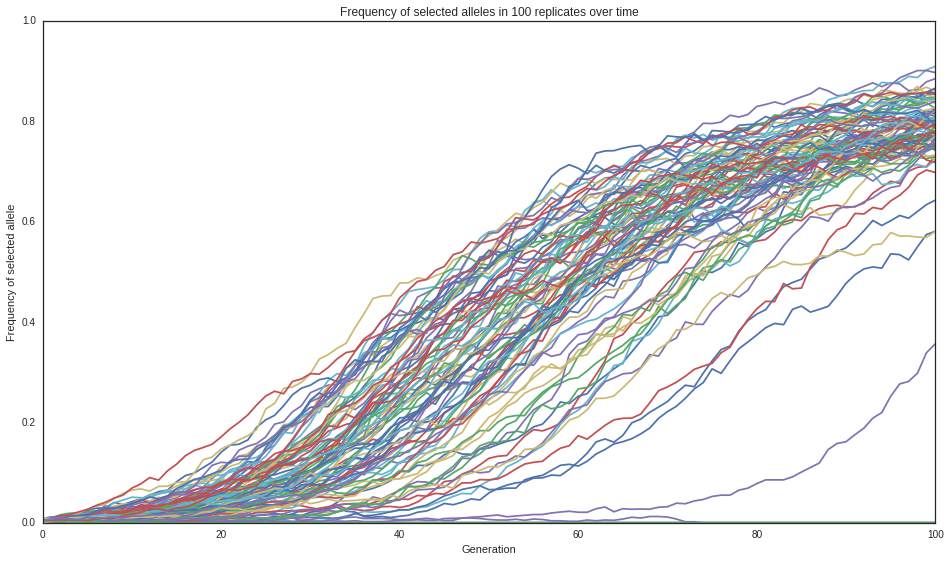

In [12]:
sns.set_style('white')
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_title('Frequency of selected alleles in 100 replicates over time')
ax.set_xlabel('Generation')
ax.set_ylabel('Frequency of selected allele')
for pop in sim.populations():
    ax.plot(pop.vars()['freq_sel'])

In [13]:
pop_size = 100
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['fitness'])

In [14]:
init_ops['Freq-sel'] = sp.PyOperator(create_derived_by_count, param=(0, 1))
sim = sp.Simulator(pops, rep=100)  # talk about threads
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)
None

0 0.005
10 0.090
20 0.190
30 0.255
40 0.430
50 0.510
60 0.600
70 0.710
80 0.655
90 0.745
100 0.825


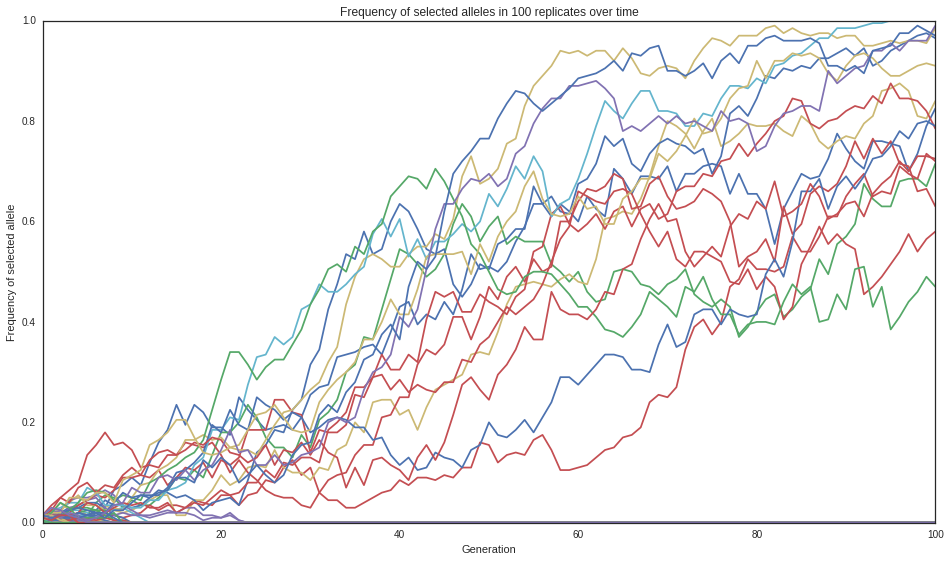

In [15]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_xlabel('Generation')
ax.set_ylabel('Frequency of selected allele')
ax.set_title('Frequency of selected alleles in 100 replicates over time')
for pop in sim.populations():
    ax.plot(pop.vars()['freq_sel'])

In [16]:
#suggest comparing with neutral

In [17]:
hz_ms = sp.MapSelector(loci=0, fitness={
                (0, 0): 0.9,
                (0, 1): 0.9,
                (1, 1): 1})
hz_mating_scheme = sp.RandomMating(ops=[sp.MendelianGenoTransmitter(), hz_ms])

In [18]:
recessive_ms = sp.MapSelector(loci=0, fitness={
                (0, 0): 0.9,
                (0, 1): 0.9,
                (1, 1): 1})
recessive_mating_scheme = sp.RandomMating(ops=[sp.MendelianGenoTransmitter(), recessive_ms])

In [19]:
# talk about multi-loci

In [20]:
pop_size = 5000
num_gens = 100
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['fitness'])

In [21]:
def example_epistasis(geno):
    if geno[0] + geno[1] == 0:
        return 0.7
    elif geno[2] + geno[3] == 0:
        return 0.8
    else:
        return 0.9 + 0.1 * (geno[2] + geno[3] - 1)

In [22]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()
init_ops['Sex'] = sp.InitSex()
init_ops['Freq-sel'] = sp.InitGenotype(freq=[0.99, 0.01], loci=[0, 1])
init_ops['Freq-neutral'] = sp.InitGenotype(freq=[0.5, 0.5], loci=range(2, num_loci))
pre_ops['Selection'] = sp.PySelector(loci=[0, 1], func=example_epistasis)
init_ops['acumulators'] = sp.PyOperator(init_acumulators, param=['freq_sel_major', 'freq_sel_minor'])
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL)
post_ops['FreqSelMajor'] = sp.PyOperator(get_freq_deriv, param=(0, 'FreqSelMajor'))
post_ops['FreqSelMinor'] = sp.PyOperator(get_freq_deriv, param=(1, 'FreqSelMinor'))
post_ops['freq_sel_major_acumulation'] = sp.PyOperator(update_acumulator, param=('freq_sel_major', 'FreqSelMajor'))
post_ops['freq_sel_minor_acumulation'] = sp.PyOperator(update_acumulator, param=('freq_sel_minor', 'FreqSelMinor'))

In [23]:
sim = sp.Simulator(pops, rep=15)
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)
None

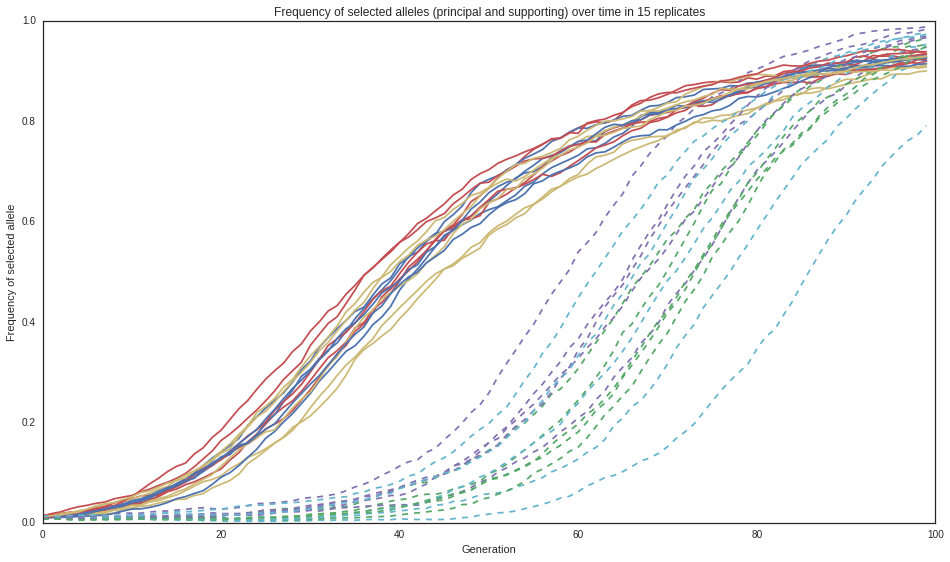

In [26]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Frequency of selected allele')
ax1.set_title('Frequency of selected alleles (principal and supporting) over time in 15 replicates')
for pop in sim.populations():
    ax1.plot(pop.vars()['freq_sel_major'])
    ax1.plot(pop.vars()['freq_sel_minor'], '--')